# MarTech Challenge 用户购买预测

## 当前项目目录

In [ ]:
root_dir = "/home/aistudio"
work_dir = "/home/aistudio/work"
model_dir = "/home/aistudio/models"
test_file = "/home/aistudio/data/data19383/submission.csv"
train_file = "/home/aistudio/data/data19383/train.csv"
simhei_font = "/home/aistudio/font/simhei.ttf"


## 引入工具包

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta

import matplotlib.pyplot as plt
from IPython import display

from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=simhei_font, size=12)

## 删除文件

In [ ]:
for i in range(11,64):
    try:
        model_name = "svm_sub"+str(i)+".joblib"
        model_file = os.path.join(root_dir,model_name)
        os.remove(model_file)
    except:
        continue

## 数据预览

### train.csv数据预览

In [ ]:
train_data = pd.read_csv(train_file)
train_data.head()

,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_pay_time,order_status,order_count,is_customer_rate,...,customer_gender,member_status,is_member_actived,goods_id,goods_class_id,goods_price,goods_status,goods_has_discount,goods_list_time,goods_delist_time
0,1000000,1000000,1.0,239.9,96.9,0.0,2012-11-01 00:10:56,6,1.0,0.0,...,NaN,NaN,NaN,998,998,54.909289,1.0,0.0,2014-10-25 11:08:07,2014-11-01 11:08:07
1,1001530,1001327,2.0,288.0,96.9,0.0,2013-08-31 23:14:42,6,2.0,0.0,...,NaN,NaN,NaN,1953,1953,45.961352,0.0,1.0,2013-08-28 17:27:50,2013-09-01 00:38:17
2,1001531,1001327,2.0,288.0,96.9,0.0,2013-08-31 23:14:42,6,2.0,0.0,...,NaN,NaN,NaN,1083,1083,53.035439,1.0,0.0,2014-10-29 18:21:05,2014-11-05 18:21:05
3,1001532,1001328,3.0,180.0,89.7,0.0,2013-08-31 22:06:35,6,1.0,0.0,...,NaN,NaN,NaN,1013,1013,46.046917,1.0,1.0,2014-10-25 11:00:00,2014-11-01 11:00:00
4,1001533,1001329,1.0,159.9,65.9,0.0,2013-08-31 21:33:36,6,1.0,0.0,...,NaN,NaN,NaN,1628,1628,50.722161,1.0,0.0,2014-10-23 15:35:33,2014-10-30 15:35:33


In [ ]:
train_data.shape

(2306871, 29)

### train.csv字段说明

| 字段 | 说明 |
|---|---|
|order_detail_id|	订单详情id|
|order_id|	订单id|
|order_total_num|	订单商品总购买数量|
|order_amount|	订单商品总金额|
|order_total_payment|	订单实付金额|
|order_total_discount|	订单优惠金额|
|order_pay_time|	付款时间|
|order_status|	订单状态： 1表示等待买家付款， 2表示卖家部分发货， 3表示卖家发货， 4表示等待买家确认收货， 5表示买家已签收， 6表示交易成功|
|order_count|	订单包含的子订单数量|
|is_customer_rate|	用户是否评价，0没有评价，1已经评价|
|order_detail_status|	订单详细状态|
|order_detail_good_num|	订单中的商品数量|
|order_detail_amount|	订单应付总金额|
|order_detail_payment|	订单实付金额|
|order_detail_discount|	订单优惠金额|
|member_id|	会员id|
|customer_id|	用户id|
|customer_gender|	性别：0未知，1男，2女|
|customer_province|	用户省份所在地|
|customer_city|	用户城市所在地|
|member_status|	会员状态：1正常，2冻结，3已删除|
|is_member_active|	会员是否激活：0没有激活，1已激活|
|goods_id|	商品id|
|goods_class_id|	商品分类id|
|goods_price|	商品原始价格|
|goods_status|	商品库存状态：1出售中，2库中|
|goods_has_discount|	是否支持会员折扣：0不支持，1支持|
|goods_list_time|	商品最新上架时间|
|goods_delist_time|	商品最新下架时间|



### submission.csv数据预览

In [ ]:
test_data = pd.read_csv(test_file)
test_data.head()

,customer_id,result
0,1000000,0.0
1,1000014,0.0
2,1000034,0.0
3,1000046,0.0
4,1000048,0.0


In [ ]:
test_data.shape

(1585986, 2)

### submission.csv 字段说明

| 字段 | 说明 |
|---|---|
|customer_id | 用户id|
|result	|下个月是否会购买：0 不购买，1购买|

## 数据预处理

### 查看数据类型、缺失情况

In [ ]:
def data_dtypes_and_miss_count(data):
    """
    data:输入数据

    返回数据类型及缺失情况
    """
    # 数据类型
    dtype = pd.DataFrame(data.dtypes)
    dtype.columns = ['dtype']

    # 数据缺失值统计
    count = pd.DataFrame(train_data.count())
    count.columns = ['count']
    count_na = pd.DataFrame(data.isna().sum())
    count_na.columns = ['count_na']


    # 数据合并
    result = pd.merge(left=dtype,right=count,how = 'left',left_index=True, right_index=True)
    result = pd.merge(left=result,right=count_na,how = 'left',left_index=True, right_index=True)
    
    return result

In [ ]:
data_dtypes_and_miss_count(train_data)

,dtype,count,count_na
order_detail_id,int64,2306871,0
order_id,int64,2306871,0
order_total_num,float64,2306871,0
order_amount,float64,2306871,0
order_total_payment,float64,2306871,0
order_total_discount,float64,2306871,0
order_pay_time,object,2306871,0
order_status,int64,2306871,0
order_count,float64,2306871,0
is_customer_rate,float64,2306871,0


从上表中可以得出，存在缺失值的特征列有：
- customer_province：用户省份所在地
- customer_city：用户城市所在地
- customer_gender：性别：0未知，1男，2女
- member_status：会员状态：1正常，2冻结，3已删除
- is_member_actived：会员是否激活：0没有激活，1已激活
- goods_price：商品原始价格

### 内存优化脚本

In [ ]:
mem_train = train_data.memory_usage(index=True).sum()

print(u"训练集占用内存："+ str(mem_train/ 1024**2)+" MB")

训练集占用内存：510.40096282958984 MB


In [ ]:
# @from: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65/code
# @liscense: Apache 2.0
# @author: weijian
def reduce_mem_usage(props):
    # 计算当前内存
    start_mem_usg = props.memory_usage().sum() / 1024 ** 2
    print("当前数据占用内存:", start_mem_usg, "MB")
    
    # 哪些列包含空值，空值用-999填充。why：因为np.nan当做float处理
    NAlist = []
    for col in props.columns:
        # 这里只过滤了object格式，如果你的代码中还包含其他类型，请一并过滤
        # if isinstance(props[col].dtypes,int64)
        if (props[col].dtypes != object):
            
            print("**************************")
            print("columns: ", col)
            print("dtype before", props[col].dtype)
            
            # 整数不支持NA，因此需要填充NA
            if not np.isfinite(props[col]).all():
                NAlist.append(col)
                props[col].fillna(-999, inplace=True) # 用-999填充

            # 判断是否是int类型
            isInt = False
            mmax = props[col].max()
            mmin = props[col].min()

            # 测试该列是否可以转换为整数
            # asint = props[col].fillna(0).astype(np.int64)
            asint = props[col].astype(np.int64)
            result = np.fabs(props[col] - asint)
            result = result.sum()
            # 绝对误差和小于0.01认为可以转换的，要根据task修改
            if result < 0.01: 
                isInt = True
            
            # make interger / unsigned Integer datatypes
            if isInt:
                if mmin >= 0: # 最小值大于0，转换成无符号整型
                    if mmax <= 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mmax <= 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mmax <= 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else: # 转换成有符号整型
                    if mmin > np.iinfo(np.int8).min and mmax < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mmin > np.iinfo(np.int16).min and mmax < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mmin > np.iinfo(np.int32).min and mmax < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mmin > np.iinfo(np.int64).min and mmax < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)  
            else:# 注意：这里对于float都转换成float16，需要根据你的情况自己更改
                if mmin > np.finfo(np.float16).min and mmax < np.finfo(np.float16).max:
                    props[col] = props[col].astype(np.float16)
                elif mmin > np.finfo(np.float32).min and mmax < np.finfo(np.float32).max:
                    props[col] = props[col].astype(np.float32)
                elif mmin > np.finfo(np.float64).min and mmax < np.finfo(np.float64).max:
                    props[col] = props[col].astype(np.float64)      
            
            print("dtype after", props[col].dtype)
            print("********************************")
    print("转换后的内存占用情况：")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("占用内存: ",mem_usg," MB")
    print("转换后的内存是初始内存的",100*mem_usg/start_mem_usg,"%")
    return props, NAlist

In [ ]:
train_data,NA_columns = reduce_mem_usage(train_data)

当前数据占用内存: 510.40096282958984 MB
**************************
columns:  order_detail_id
dtype before int64
dtype after uint32
********************************
**************************
columns:  order_id
dtype before int64
dtype after uint32
********************************
**************************
columns:  order_total_num
dtype before float64
dtype after uint16
********************************
**************************
columns:  order_amount
dtype before float64
dtype after float32
********************************
**************************
columns:  order_total_payment
dtype before float64
dtype after float32
********************************
**************************
columns:  order_total_discount
dtype before float64
dtype after float16
********************************
**************************
columns:  order_status
dtype before int64
dtype after uint8
********************************
**************************
columns:  order_count
dtype before float64
dtype after uint32
*****

In [ ]:
train_data.dtypes

order_detail_id            uint32
order_id                   uint32
order_total_num            uint16
order_amount              float32
order_total_payment       float32
order_total_discount      float16
order_pay_time             object
order_status                uint8
order_count                uint32
is_customer_rate            uint8
order_detail_status         uint8
order_detail_goods_num     uint16
order_detail_amount       float32
order_detail_payment      float32
order_detail_discount     float32
customer_province          object
customer_city              object
member_id                  uint32
customer_id                uint32
customer_gender             int16
member_status               int16
is_member_actived           int16
goods_id                   uint16
goods_class_id             uint16
goods_price               float16
goods_status                uint8
goods_has_discount          uint8
goods_list_time            object
goods_delist_time          object
dtype: object

In [ ]:
NA_columns

['customer_gender', 'member_status', 'is_member_actived', 'goods_price']

### 处理日期

In [ ]:
def handling_date(data,date_cols):
    """
    date：输入数据
    date_cols:需要转换的列名
    """
    for col in date_cols:

        print("**************************")
        print("columns: ", col)
        
        data[col]=pd.to_datetime(data[col],format="%Y-%m-%d %H:%M:%S")

    return data

In [ ]:
train_data = handling_date(train_data,['goods_list_time','order_pay_time','goods_delist_time'])

**************************
columns:  goods_list_time
**************************
columns:  order_pay_time
**************************
columns:  goods_delist_time


In [ ]:
train_data.head()

,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_pay_time,order_status,order_count,is_customer_rate,...,customer_gender,member_status,is_member_actived,goods_id,goods_class_id,goods_price,goods_status,goods_has_discount,goods_list_time,goods_delist_time
0,1000000,1000000,1,239.899994,96.900002,0.0,2012-11-01 00:10:56,6,1,0,...,-999,-999,-999,998,998,54.90625,1,0,2014-10-25 11:08:07,2014-11-01 11:08:07
1,1001530,1001327,2,288.000000,96.900002,0.0,2013-08-31 23:14:42,6,2,0,...,-999,-999,-999,1953,1953,45.96875,0,1,2013-08-28 17:27:50,2013-09-01 00:38:17
2,1001531,1001327,2,288.000000,96.900002,0.0,2013-08-31 23:14:42,6,2,0,...,-999,-999,-999,1083,1083,53.03125,1,0,2014-10-29 18:21:05,2014-11-05 18:21:05
3,1001532,1001328,3,180.000000,89.699997,0.0,2013-08-31 22:06:35,6,1,0,...,-999,-999,-999,1013,1013,46.06250,1,1,2014-10-25 11:00:00,2014-11-01 11:00:00
4,1001533,1001329,1,159.899994,65.900002,0.0,2013-08-31 21:33:36,6,1,0,...,-999,-999,-999,1628,1628,50.71875,1,0,2014-10-23 15:35:33,2014-10-30 15:35:33


In [ ]:
train_data.dtypes

order_detail_id                   uint32
order_id                          uint32
order_total_num                   uint16
order_amount                     float32
order_total_payment              float32
order_total_discount             float16
order_pay_time            datetime64[ns]
order_status                       uint8
order_count                       uint32
is_customer_rate                   uint8
order_detail_status                uint8
order_detail_goods_num            uint16
order_detail_amount              float32
order_detail_payment             float32
order_detail_discount            float32
customer_province                 object
customer_city                     object
member_id                         uint32
customer_id                       uint32
customer_gender                    int16
member_status                      int16
is_member_actived                  int16
goods_id                          uint16
goods_class_id                    uint16
goods_price     

## 探索分析

### 订单状态分布

In [ ]:
def plt_pie(data,categories,legend_title,font):
    fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect="equal"), dpi= 80)

    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}% ({:d} )".format(pct, absolute)

    wedges, texts, autotexts = ax.pie(data, 
                                      autopct=lambda pct: func(pct, data),
                                      textprops=dict(color="w"), 
                                      colors=plt.cm.Dark2.colors,
                                      startangle=140)
    
    ax.legend(wedges, categories, title=legend_title, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.setp(autotexts, size=10, weight=700)
    ax.set_title("订单状态分布",fontproperties=font)
    plt.show()


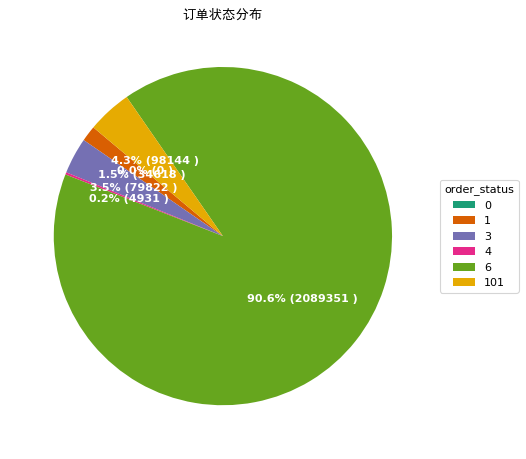

In [ ]:
order_statu = train_data.groupby(["order_status"]).size().reset_index(name='counts')

plt_pie(order_statu['counts'],order_statu['order_status'],"order_status",myfont)

由此可以看出，完成交易数据占总数据的90%左右，以下将筛选出完成交易的订单量。

### 性别分布

#### 完成交易的性别分布情况：

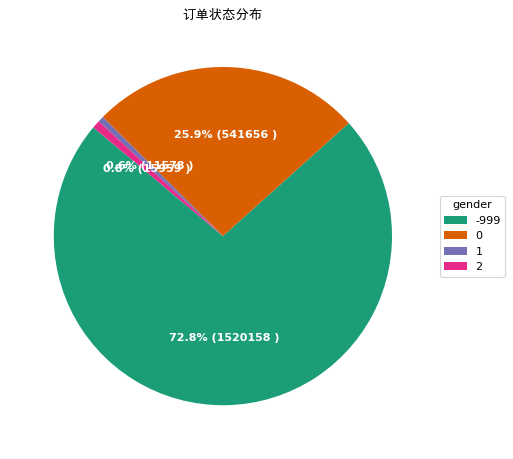

In [ ]:
gender = train_data[train_data["order_status"]==6].groupby(["customer_gender"]).size()

plt_pie(gender.values,gender.index.values,"gender",myfont)

#### 未完成交易的性别分布情况：

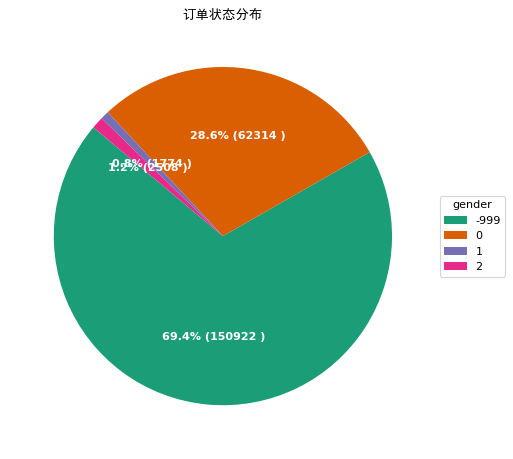

In [ ]:
gender = train_data[train_data["order_status"]!=6].groupby(["customer_gender"]).size()

plt_pie(gender.values,gender.index.values,"gender",myfont)

### 商品分析

In [ ]:
train_data.columns

Index(['order_detail_id', 'order_id', 'order_total_num', 'order_amount',
       'order_total_payment', 'order_total_discount', 'order_pay_time',
       'order_status', 'order_count', 'is_customer_rate',
       'order_detail_status', 'order_detail_goods_num', 'order_detail_amount',
       'order_detail_payment', 'order_detail_discount', 'customer_province',
       'customer_city', 'member_id', 'customer_id', 'customer_gender',
       'member_status', 'is_member_actived', 'goods_id', 'goods_class_id',
       'goods_price', 'goods_status', 'goods_has_discount', 'goods_list_time',
       'goods_delist_time'],
      dtype='object')

分析特征如下：

- order_detail_id	订单详情id
- order_id	订单id
- order_status	订单状态： 1表示等待买家付款， 2表示卖家部分发货， 3表示卖家发货， 4表示等待买家确认收货， 5表示买家已签收， 6表示交易成功
- goods_id	商品id
- goods_class_id	商品分类id
- goods_price	商品原始价格
- goods_status	商品库存状态：1出售中，2库中
- goods_has_discount	是否支持会员折扣：0不支持，1支持
- goods_list_time	商品最新上架时间
- goods_delist_time	商品最新下架时间

#### 买家已签收的商品分布情况

## 特征工程

In [ ]:

train_data.columns

Index(['order_detail_id', 'order_id', 'order_total_num', 'order_amount',
       'order_total_payment', 'order_total_discount', 'order_pay_time',
       'order_status', 'order_count', 'is_customer_rate',
       'order_detail_status', 'order_detail_goods_num', 'order_detail_amount',
       'order_detail_payment', 'order_detail_discount', 'customer_province',
       'customer_city', 'member_id', 'customer_id', 'customer_gender',
       'member_status', 'is_member_actived', 'goods_id', 'goods_class_id',
       'goods_price', 'goods_status', 'goods_has_discount', 'goods_list_time',
       'goods_delist_time'],
      dtype='object')

### 问题分析

问题的主要目的是：
- 通过品牌商家的历史订单数据构建预测模型，预估用户人群在下个月内产生购买行为的概率

问题中主要有两个关键词：
- 下个月内：预测某一时间段内的事件，首先想到的是时间序列分析
- 用户的购买行为：此处将是否完成交易作为是否存在购买行为的标准



### 初始特征筛选

从原始数据集中筛选出的特征如下：

- order_id，订单id
- order_pay_time，付款时间
- customer_id，用户id
- customer_gender，性别：0未知，1男，2女
- member_status，会员状态：1正常，2冻结，3已删除
- order_total_payment，订单实付金额
- order_status，订单状态： 1表示等待买家付款， 2表示卖家部分发货， 3表示卖家发货， 4表示等待买家确认收货， 5表示买家已签收， 6表示交易成功

In [ ]:
customer_cols = ["order_id","order_pay_time","customer_id","customer_gender","member_status","order_total_payment","order_status"]

In [ ]:
customer_features = train_data[customer_cols]
customer_features.sort_values(["customer_id","order_pay_time"]).head()

,order_id,order_pay_time,customer_id,customer_gender,member_status,order_total_payment,order_status
0,1000000,2012-11-01 00:10:56,1000000,-999,-999,96.900002,6
155115,1155016,2013-08-03 21:34:49,1000014,-999,-999,66.900002,6
157749,1157250,2013-03-08 10:21:29,1000034,-999,-999,99.900002,6
157750,1157250,2013-03-08 10:21:29,1000034,-999,-999,99.900002,6
126898,1126955,2013-06-07 12:44:54,1000046,-999,-999,39.900002,6


### 构建模型特征

筛选出已**完成交易的订单数据**：

In [ ]:
customer_features = customer_features[customer_features["order_status"]==6]
customer_features.shape

(2089352, 7)

去重：

In [ ]:
customer_features = customer_features.drop_duplicates()
customer_features.shape

(1741558, 7)

In [ ]:
customer_features.to_csv("customer_features.csv",index=False)

**待构建模型特征**如下：

- 用户性别
- 会员状态
- 购物频率(平均每次购物间隔时长)
- 距离最近一次消费的间隔
- 平均每个月的购物支出
- 连续消费月数(待添加)
- 月支出的方差(待添加)


以预测月份的前6个月为输入，则可构造4份训练数据集：

- 输入日期范围：2012-11 至 2013-04，标签月份是5月
- 输入日期范围：2012-12 至 2013-05，标签月份是6月
- 输入日期范围：2013-01 至 2013-06，标签月份是7月
- 输入日期范围：2013-02 至 2013-07，标签月份是8月

#### 建模特征1

**第1步**，利用原始数据获取以下特征：

- 用户性别
- 会员状态
- 购物频率(平均每次购物间隔时长)
- 距离最近一次消费的间隔

In [ ]:
def get_model_feature1(data,cur_date="2013-08-01"):
    """
    根据原始数据提取建模相关特征
    """
    # 用户id
    customer_data = []
    customer_ids = data["customer_id"].drop_duplicates()
    l = len(customer_ids)
    i = 1

    for cid in customer_ids:
        # print("#########################################")
        # print(cid)
        customer = {}

        # 获取用户数据
        grouped = data[data["customer_id"]==cid].sort_values("order_pay_time")

        # 获取客户ID
        customer["customer_id"] = cid

        # 用户性别
        customer["gender"] = grouped["customer_gender"].to_list()[-1]

        # 会员状态
        customer["member_status"] = grouped["member_status"].to_list()[-1]

        # 距离最近一次的购物间隔
        cur_datetime = pd.to_datetime(cur_date)
        customer["buy_last"] = (cur_datetime-grouped["order_pay_time"].to_list()[-1])/np.timedelta64(1, "D")

        # 购物频率
        buy_times = len(grouped["order_pay_time"].drop_duplicates())   #购物次数
        buy_period = (cur_datetime-grouped["order_pay_time"].to_list()[0])/np.timedelta64(1, "D")
        customer["buy_period"] = buy_period/buy_times

        customer_data.append(customer)
        p = np.round(i/l*100,4)
        print("\rProgress: {}/{}--{}%".format(i,l,p), end="")
        sys.stdout.flush()
        i += 1

    return pd.DataFrame(customer_data)

In [ ]:
temp = customer_features[customer_features["order_pay_time"]<pd.to_datetime("2013-08-01")]
model_feature1 = get_model_feature1(temp)

del temp

Progress: 1341878/1341878

In [ ]:
model_feature1.head()

,customer_id,gender,member_status,buy_last,buy_period
0,1000000,-999,-999,272.992407,272.992407
1,1002163,-999,-999,0.065382,0.065382
2,1002164,-999,-999,0.160648,0.160648
3,1002165,-999,-999,0.276007,0.276007
4,1002166,-999,-999,0.438704,0.438704


In [ ]:
model_feature1.to_csv("train_model_feature1.csv",index=False)

#### 建模特征2

**第2步**，构建出每个用户每月支出数据：

In [ ]:
temp = customer_features[['order_pay_time','customer_id','order_total_payment']]
temp['order_pay_time'] = temp['order_pay_time'].dt.date
day_payment = temp.groupby(['order_pay_time','customer_id']).sum()

del temp

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
day_payment = day_payment.unstack('customer_id', fill_value=0)
day_payment.columns = day_payment.columns.get_level_values("customer_id")
day_payment.columns.rename(None,inplace=True)

day_payment.index = pd.to_datetime(day_payment.index.get_level_values("order_pay_time"))
day_payment.index.rename(None,inplace=True)
day_payment.head()

,1000000,1000014,1000034,1000046,1000048,1000069,1000084,1000099,1000105,1000109,...,2826561,2826564,2826566,2826567,2826569,2826570,2826571,2826572,2826573,2826574
2012-11-01,96.900002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-11-02,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-11-03,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-11-04,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-11-05,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
month_payment = day_payment.resample("m").sum().T
month_payment = month_payment.applymap(lambda x: round(x,2))
month_payment.index.rename("customer_id", inplace=True)
month_payment.reset_index(inplace=True)
month_payment.head()

,customer_id,2012-11-30 00:00:00,2012-12-31 00:00:00,2013-01-31 00:00:00,2013-02-28 00:00:00,2013-03-31 00:00:00,2013-04-30 00:00:00,2013-05-31 00:00:00,2013-06-30 00:00:00,2013-07-31 00:00:00,2013-08-31 00:00:00
0,1000000,96.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1000014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.9
2,1000034,0.0,0.0,0.0,0.0,99.9,0.0,0.0,0.0,0.0,0.0
3,1000046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.9,0.0,0.0
4,1000048,0.0,89.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
month_payment.to_csv("month_payment.csv",index=False)

**第3步**，基于上述得到的每个用户月消费数据，构建以下建模特征：

- 平均每个月的购物支出
- 连续消费月数

In [ ]:
def get_model_feature2(data):
    s1 = data["customer_id"]
    s2 = data.iloc[:,1:-1].sum(axis=1)/9
    s3 = data.iloc[:,1:-1].std(axis=1)
    s4 = data.iloc[:,1:-1].var(axis=1)
    s5 = (data.iloc[:,-1]>0)+0
    
    return pd.DataFrame({"customer_id":s1,"pay_mean":s2,"pay_std":s3,"pay_var":s4,"label":s5})

In [ ]:
model_feature2 = get_model_feature2(month_payment)

In [ ]:
model_feature2.head()

,customer_id,pay_mean,pay_std,pay_var,label
0,1000000,10.766667,32.300000,1043.290000,0
1,1000014,0.000000,0.000000,0.000000,1
2,1000034,11.100000,33.300000,1108.890000,0
3,1000046,4.433333,13.300000,176.890000,0
4,1000048,9.988889,29.966667,898.001111,0


In [ ]:
model_feature2.to_csv("train_model_feature2.csv",index=False)

### 特征合并

#### 加载已保存数据

In [ ]:
model_feature1 = pd.read_csv("train_model_feature1.csv")
model_feature2 = pd.read_csv("train_model_feature2.csv")

In [ ]:
model_feature1.shape,model_feature2.shape

((1341878, 5), (1482614, 5))

In [ ]:
model_feature = pd.merge(left=model_feature1,right=model_feature2,how="left",on="customer_id")

In [ ]:
model_feature

,customer_id,gender,member_status,buy_last,buy_period,pay_mean,pay_std,pay_var,label
0,1000000,-999,-999,272.992407,272.992407,10.766667,32.300000,1043.290000,0
1,1002163,-999,-999,0.065382,0.065382,10.988889,32.966667,1086.801111,0
2,1002164,-999,-999,0.160648,0.160648,10.411111,31.233333,975.521111,0
3,1002165,-999,-999,0.276007,0.276007,6.422222,19.266667,371.204444,0
4,1002166,-999,-999,0.438704,0.438704,10.988889,32.966667,1086.801111,0
...,...,...,...,...,...,...,...,...,...
1341873,2826569,0,1,231.999826,131.499913,43.955556,104.167703,10850.910278,0
1341874,2826571,0,1,194.565984,194.565984,6.655556,19.966667,398.667778,0
1341875,2826572,0,1,188.982870,131.133652,56.430000,112.244588,12598.847550,0
1341876,2826573,0,1,202.191308,202.191308,6.655556,19.966667,398.667778,0


### 构建哑变量

In [75]:
gender_onehot = pd.get_dummies(model_feature["gender"], dtype=np.float32)

gender_onehot.head()

,-999,0,1,2
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [78]:
model_feature["gender_na"] = gender_onehot[-999]
model_feature["gender_0"] = gender_onehot[0]
model_feature["gender_1"] = gender_onehot[1]
model_feature["gender_2"] = gender_onehot[2]
model_feature.head()

,customer_id,gender,member_status,buy_last,buy_period,pay_mean,pay_std,pay_var,label,gender_na,gender_0,gender_1,gender_2
0,1000000,-999,-999,0.0000,0.0000,0.0010,0.9990,1.0,0,1.0,0.0,0.0,0.0
1,1002163,-999,-999,0.9998,0.9998,0.0010,0.9990,1.0,0,1.0,0.0,0.0,0.0
2,1002164,-999,-999,0.9994,0.9994,0.0010,0.9990,1.0,0,1.0,0.0,0.0,0.0
3,1002165,-999,-999,0.9990,0.9990,0.0006,0.9994,1.0,0,1.0,0.0,0.0,0.0
4,1002166,-999,-999,0.9984,0.9984,0.0010,0.9990,1.0,0,1.0,0.0,0.0,0.0


### 归一化

In [ ]:
def normalization_max(x):
    """
    正向归一化
    """
    x = np.array(x)
    ma = x.max()+0.0001
    mi = x.min()-0.0001
    
    return ((x-mi)/(ma-mi)).round(4)

def normalization_min(x):
    """
    反向归一化
    """
    x = np.array(x)
    ma = x.max()+0.0001
    mi = x.min()-0.0001
    
    return ((ma-x)/(ma-mi)).round(4)

In [ ]:
model_feature["buy_last"] = normalization_min(model_feature["buy_last"])
model_feature["buy_period"] = normalization_min(model_feature["buy_period"])
model_feature["pay_mean"] = normalization_max(model_feature["pay_mean"])
model_feature["pay_std"] = normalization_min(model_feature["pay_std"])
model_feature["pay_var"] = normalization_min(model_feature["pay_var"])

In [ ]:
model_feature

,customer_id,gender,member_status,buy_last,buy_period,pay_mean,pay_std,pay_var,label
0,1000000,-999,-999,0.0000,0.0000,0.0010,0.9990,1.0,0
1,1002163,-999,-999,0.9998,0.9998,0.0010,0.9990,1.0,0
2,1002164,-999,-999,0.9994,0.9994,0.0010,0.9990,1.0,0
3,1002165,-999,-999,0.9990,0.9990,0.0006,0.9994,1.0,0
4,1002166,-999,-999,0.9984,0.9984,0.0010,0.9990,1.0,0
...,...,...,...,...,...,...,...,...,...
1341873,2826569,0,1,0.1502,0.5183,0.0040,0.9968,1.0,0
1341874,2826571,0,1,0.2873,0.2873,0.0006,0.9994,1.0,0
1341875,2826572,0,1,0.3078,0.5197,0.0052,0.9966,1.0,0
1341876,2826573,0,1,0.2594,0.2594,0.0006,0.9994,1.0,0


### 不平衡数据处理

In [ ]:
model_feature.groupby(["label"]).size()

label
0    1321808
1      20070
dtype: int64

#### 下采样

In [80]:
data_sample = pd.concat([model_feature[model_feature["label"]==0].sample(n=20200, 
                                                                         replace=False, 
                                                                         weights=None, 
                                                                         random_state=1, 
                                                                         axis=0),
                         model_feature[model_feature["label"]==1]])

In [ ]:
class subsample(object):
    """
    加载数据
    """
    def __init__(self, data, batch_size, shuffle=True):
        # 初始数据和标签
        self.data = data
        # 批量大小
        self.batch_size = batch_size
        # 是否打乱，默认打乱数据集，只针对训练集
        self.shuffle = shuffle

    def __getitem__(self, index):
        """
        根据下标返回数据及标签
        """
        return self.data[index]

    def __iter__(self):
        """
        迭代器
        """
        # 获取数据量
        datasize = self.data.shape[0]
        print("样本数量:",datasize)
        # 生成迭代序列
        data_seq = np.arange(datasize)
        
        if self.shuffle:
            # 打乱迭代序列
            np.random.shuffle(data_seq)

        print("采样序列：",data_seq[:20])    
        
        # 生成的是 Batch 序列
        interval_list = np.append(
            np.arange(0, datasize, self.batch_size), datasize)
        print("Batch端点:",interval_list)
        for index in range(interval_list.shape[0]-1):
            s = data_seq[interval_list[index]:interval_list[index+1]]
            
            # 返回 batch 的数据
            yield self.data.iloc[s,:]

    def __len__(self):
        # 返回数据集长度
        return self.data.shape[0]

## 构建模型

In [86]:
# 集成方法分类器
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
# 高斯过程分类器
from sklearn.gaussian_process import GaussianProcessClassifier
# 广义线性分类器
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
# K近邻分类器
from sklearn.neighbors import KNeighborsClassifier
# 朴素贝叶斯分类器
from sklearn.naive_bayes import GaussianNB
# 神经网络分类器
from sklearn.neural_network import MLPClassifier
# 决策树分类器
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
# 支持向量机分类器
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
# 优化器
from sklearn.model_selection import GridSearchCV  #网格搜索
from sklearn.model_selection import RandomizedSearchCV   #随机采样

from sklearn.preprocessing import OneHotEncoder
from joblib import dump, load     #模型保存与加载

from sklearn.model_selection import train_test_split  # 导入数据集划分模块
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,make_scorer,roc_auc_score  # 导入评估模块

### 数据集划分

In [81]:
feature = data_sample[["buy_last","buy_period","pay_mean","pay_std","pay_var","gender_na","gender_0","gender_1","gender_2"]]  # 指定特征
target = data_sample["label"]  # 指定目标值

# 划分数据集，将其中 80% 划为训练集，另 20% 作为测试集
train_feature, val_feature, train_target, val_target = train_test_split(
    feature, target, test_size=0.2)


### 常见监督学习算法对比

In [ ]:
# 建立模型
models = [
    AdaBoostClassifier(),
    BaggingClassifier(),
    ExtraTreesClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(),
    GaussianProcessClassifier(),
    PassiveAggressiveClassifier(),
    RidgeClassifier(),
    SGDClassifier(),
    KNeighborsClassifier(),
    GaussianNB(),
    MLPClassifier(),
    DecisionTreeClassifier(),
    ExtraTreeClassifier(),
    SVC(),
    LinearSVC()
]

# 依次为模型命名
classifier_Names = ['AdaBoost', 'Bagging', 'ExtraTrees',
                    'GradientBoosting', 'RandomForest', 'GaussianProcess',
                    'PassiveAggressive', 'Ridge', 'SGD',
                    'KNeighbors', 'GaussianNB', 'MLP',
                    'DecisionTree', 'ExtraTree', 'SVC', 'LinearSVC']

In [ ]:
# 遍历所有模型
for name, model in zip(classifier_Names, models):
    model.fit(train_feature, train_target)  # 训练模型
    pre_labels = model.predict(val_feature)  # 模型预测
    score = accuracy_score(val_target, pre_labels)  # 计算预测准确度
    print('%s: %.4f' % (name, score))  # 输出模型准确度

AdaBoost: 0.70
Bagging: 0.65
ExtraTrees: 0.65
GradientBoosting: 0.71


### 神经网络分类(MLPClassifier)

In [87]:
MLP = MLPClassifier()
MLP.fit(train_feature, train_target)  # 训练模型
results = MLP.predict(val_feature)  # 模型预测

# 模型评估
acc_scores = accuracy_score(val_target, results)  # 预测精准度
pre_scores = precision_score(val_target, results)
recal_scores = recall_score(val_target, results)
f1_scores = f1_score(val_target, results)
auc_scores = roc_auc_score(val_target, results)

print("准确率: {:.4f}".format(acc_scores))
print("精确率: {:.4f}".format(pre_scores))
print("召回率: {:.4f}".format(recal_scores))
print("F1值: {:.4f}".format(f1_scores))
print("AUC值: {:.4f}".format(auc_scores))

# 保存模型
model_name = 'MLPClassifier_acc_{:.4f}.joblib'.format(acc_scores)
model_path = os.path.join(model_dir,model_name)
dump(MLP, model_path)

准确率: 0.7141
精确率: 0.7165
召回率: 0.6936
F1值: 0.7049
AUC值: 0.7137


['/home/aistudio/models/MLPClassifier_acc_0.7141.joblib']

### GradientBoosting

In [88]:
GBC = GradientBoostingClassifier()
GBC.fit(train_feature, train_target)  # 训练模型
results = GBC.predict(val_feature)  # 模型预测

# 模型评估
acc_scores = accuracy_score(val_target, results)  # 预测精准度
pre_scores = precision_score(val_target, results)
recal_scores = recall_score(val_target, results)
f1_scores = f1_score(val_target, results)
auc_scores = roc_auc_score(val_target, results)

print("准确率: {:.4f}".format(acc_scores))
print("精确率: {:.4f}".format(pre_scores))
print("召回率: {:.4f}".format(recal_scores))
print("F1值: {:.4f}".format(f1_scores))
print("AUC值: {:.4f}".format(auc_scores))

# 保存模型
model_name = 'GradientBoosting_acc_{:.4f}.joblib'.format(acc_scores)
model_path = os.path.join(model_dir,model_name)
dump(GBC, model_path)

准确率: 0.7147
精确率: 0.7163
召回率: 0.6961
F1值: 0.7061
AUC值: 0.7144


['/home/aistudio/models/GradientBoosting_acc_0.7147.joblib']

### 支持向量机

In [89]:
model_svc = SVC()  # 建立模型
model_svc.fit(train_feature, train_target)  # 模型训练
results = model_svc.predict(val_feature)  # 模型预测

# 模型评估
acc_scores = accuracy_score(val_target, results)  # 预测精准度
pre_scores = precision_score(val_target, results)
recal_scores = recall_score(val_target, results)
f1_scores = f1_score(val_target, results)
auc_scores = roc_auc_score(val_target, results)

print("准确率: {:.4f}".format(acc_scores))
print("精确率: {:.4f}".format(pre_scores))
print("召回率: {:.4f}".format(recal_scores))
print("F1值: {:.4f}".format(f1_scores))
print("AUC值: {:.4f}".format(auc_scores))

# 保存模型
model_name = 'SVC_acc_{:.4f}.joblib'.format(acc_scores)
model_path = os.path.join(model_dir,model_name)
dump(model_svc, model_path)

准确率: 0.7056
精确率: 0.6766
召回率: 0.7702
F1值: 0.7204
AUC值: 0.7066


['/home/aistudio/models/SVC_acc_0.7056.joblib']

In [64]:
param_grid = [
    {"kernel":["linear","rbf","sigmoid"], 
    "C":[0.0001,0.001,0.01,0.1,1], 
    "degree":[1,2],"gamma":[0.0001,0.001,0.01,0.1,1]}]
score = make_scorer(accuracy_score)

model_svc = SVC()  # 建立模型
model_svc_gs = GridSearchCV(model_svc,param_grid,score,cv=3)
model_svc_gs.fit(train_feature, train_target)  # 模型训练
results = model_svc_gs.predict(val_feature)  # 模型预测

# 模型评估
acc_scores = accuracy_score(val_target, results)  # 预测精准度
pre_scores = precision_score(val_target, results)
recal_scores = recall_score(val_target, results)
f1_scores = f1_score(val_target, results)
auc_scores = roc_auc_score(val_target, results)

print("准确率: {:.4f}".format(acc_scores))
print("精确率: {:.4f}".format(pre_scores))
print("召回率: {:.4f}".format(recal_scores))
print("F1值: {:.4f}".format(f1_scores))
print("AUC值: {:.4f}".format(auc_scores))

# 保存模型
model_name = 'SVCGS_acc_{:.4f}.joblib'.format(acc_scores)
model_path = os.path.join(model_dir,model_name)
dump(model_svc_gs, model_path)

KeyboardInterrupt: 

### 随机森林

In [85]:
model_RF = RandomForestClassifier()
model_RF = model_RF.fit(train_feature, train_target)
results = model_RF.predict(val_feature)  # 模型预测

# 模型评估
acc_scores = accuracy_score(val_target, results)  # 预测精准度
pre_scores = precision_score(val_target, results)
recal_scores = recall_score(val_target, results)
f1_scores = f1_score(val_target, results)
auc_scores = roc_auc_score(val_target, results)

print("准确率: {:.4f}".format(acc_scores))
print("精确率: {:.4f}".format(pre_scores))
print("召回率: {:.4f}".format(recal_scores))
print("F1值: {:.4f}".format(f1_scores))
print("AUC值: {:.4f}".format(auc_scores))

# 保存模型
model_name = 'RandomForest_acc_{:.4f}.joblib'.format(acc_scores)
model_path = os.path.join(model_dir,model_name)
dump(model_RF, model_path)

准确率: 0.6669
精确率: 0.6635
召回率: 0.6560
F1值: 0.6597


['/home/aistudio/models/RandomForest_acc_0.6669.joblib']

### 投票选择(特殊)

In [ ]:
i = 1
for sam in subsample(model_feature[model_feature["label"]==0],20000):
    data_sample = pd.concat([sam,model_feature[model_feature["label"]==1]])
    feature = data_sample[["buy_last","buy_period","pay"]]  # 指定特征
    target = data_sample["label"]  # 指定目标值

    # 划分数据集，将其中 80% 划为训练集，另 20% 作为测试集
    train_feature, val_feature, train_target, val_target = train_test_split(
        feature, target, test_size=0.2)

    model_svc = SVC()  # 建立模型
    model_svc.fit(train_feature, train_target)  # 模型训练
    results = model_svc.predict(val_feature)  # 模型预测
    
    acc_scores = accuracy_score(val_target, results)  # 评估预测精准度
    pre_scores = precision_score(val_target, results)
    recal_scores = recall_score(val_target, results)
    f1_scores = f1_score(val_target, results)

    print("准确率: {:.3f}".format(acc_scores))
    print("精确率: {:.3f}".format(pre_scores))
    print("召回率: {:.3f}".format(recal_scores))
    print("F1值: {:.3f}".format(f1_scores))
    dump(model_svc, "svm_sub"+str(i)+".joblib")       # 保存
    i += 1
    print("#################################################")

样本数量: 1321808
采样序列： [1060811  249963  112885 1307870  263951  539400  716661 1204952  461526
  115992  979903 1137173   65530  279876  993449  276142  529345  380153
 1122647  162660]
Batch端点: [      0   20000   40000   60000   80000  100000  120000  140000  160000
  180000  200000  220000  240000  260000  280000  300000  320000  340000
  360000  380000  400000  420000  440000  460000  480000  500000  520000
  540000  560000  580000  600000  620000  640000  660000  680000  700000
  720000  740000  760000  780000  800000  820000  840000  860000  880000
  900000  920000  940000  960000  980000 1000000 1020000 1040000 1060000
 1080000 1100000 1120000 1140000 1160000 1180000 1200000 1220000 1240000
 1260000 1280000 1300000 1320000 1321808]
准确率: 0.693
精确率: 0.703
召回率: 0.662
F1值: 0.682
#################################################
准确率: 0.689
精确率: 0.714
召回率: 0.648
F1值: 0.679
#################################################
准确率: 0.695
精确率: 0.711
召回率: 0.667
F1值: 0.688
######################

## 测试集特征构建

### 测试集特征1

In [ ]:
temp = customer_features[customer_features["order_pay_time"]<pd.to_datetime("2013-09-01")]
test_feature1 = get_model_feature1(temp,"2013-09-01")

del temp

Progress: 1482614/1482614--100.0%9%

In [ ]:
test_feature1.head()

,customer_id,gender,member_status,buy_last,buy_period
0,1000000,-999,-999,303.992407,303.992407
1,1001324,-999,-999,0.031458,0.031458
2,1001325,-999,-999,0.038935,0.039381
3,1001326,-999,-999,0.101667,0.101667
4,1001327,-999,-999,0.126991,146.841950


In [ ]:
test_feature1.to_csv("test_feature1.csv",index=False)

#### 加载已保存的数据

In [94]:
test_feature1 = pd.read_csv("test_feature1.csv")

### 测试集特征2

In [95]:
def get_test_feature2(data):
    s1 = data["customer_id"]
    s2 = data.iloc[:,2:].sum(axis=1)/9
    s3 = data.iloc[:,2:].std(axis=1)
    s4 = data.iloc[:,2:].var(axis=1)
    
    return pd.DataFrame({"customer_id":s1,"pay_mean":s2,"pay_std":s3,"pay_var":s4})

In [96]:
test_feature2 = get_test_feature2(month_payment)
test_feature2.head()

,customer_id,pay_mean,pay_std,pay_var
0,1000000,0.000000,0.000000,0.000000
1,1000014,7.433333,22.300000,497.290000
2,1000034,11.100000,33.300000,1108.890000
3,1000046,4.433333,13.300000,176.890000
4,1000048,9.988889,29.966667,898.001111


### 测试集特征合并

In [97]:
test_feature = pd.merge(left=test_feature1,right=test_feature2,how="left",on="customer_id")

#### 加载已保存的测试集

In [90]:
test_feature = pd.read_csv("test_feature.csv")
test_feature.head()

,customer_id,gender,member_status,buy_last,buy_period,pay,pay_std
0,1000000,-999,-999,0.0000,0.0000,0.0000,1.0000
1,1001324,-999,-999,0.9999,0.9999,0.0010,0.9990
2,1001325,-999,-999,0.9999,0.9999,0.0029,0.9971
3,1001326,-999,-999,0.9997,0.9997,0.0007,0.9993
4,1001327,-999,-999,0.9996,0.5170,0.0007,0.9993


In [98]:
gender_onehot = pd.get_dummies(test_feature["gender"], dtype=np.float32)

gender_onehot.head()

,-999,0,1,2
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [99]:
test_feature["gender_na"] = gender_onehot[-999]
test_feature["gender_0"] = gender_onehot[0]
test_feature["gender_1"] = gender_onehot[1]
test_feature["gender_2"] = gender_onehot[2]
test_feature.head()

,customer_id,gender,member_status,buy_last,buy_period,pay_mean,pay_std,pay_var,gender_na,gender_0,gender_1,gender_2
0,1000000,-999,-999,303.992407,303.992407,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0
1,1001324,-999,-999,0.031458,0.031458,10.766667,32.300000,1043.290000,1.0,0.0,0.0,0.0
2,1001325,-999,-999,0.038935,0.039381,31.288889,93.866667,8810.951111,1.0,0.0,0.0,0.0
3,1001326,-999,-999,0.101667,0.101667,7.322222,21.966667,482.534444,1.0,0.0,0.0,0.0
4,1001327,-999,-999,0.126991,146.841950,7.433333,22.300000,497.290000,1.0,0.0,0.0,0.0


In [100]:
test_feature["buy_last"] = normalization_min(test_feature["buy_last"])
test_feature["buy_period"] = normalization_min(test_feature["buy_period"])
test_feature["pay_mean"] = normalization_max(test_feature["pay_mean"])
test_feature["pay_std"] = normalization_min(test_feature["pay_std"])
test_feature["pay_var"] = normalization_min(test_feature["pay_var"])

In [101]:
test_feature.head()

,customer_id,gender,member_status,buy_last,buy_period,pay_mean,pay_std,pay_var,gender_na,gender_0,gender_1,gender_2
0,1000000,-999,-999,0.0000,0.0000,0.0000,1.0000,1.0,1.0,0.0,0.0,0.0
1,1001324,-999,-999,0.9999,0.9999,0.0010,0.9990,1.0,1.0,0.0,0.0,0.0
2,1001325,-999,-999,0.9999,0.9999,0.0029,0.9971,1.0,1.0,0.0,0.0,0.0
3,1001326,-999,-999,0.9997,0.9997,0.0007,0.9993,1.0,1.0,0.0,0.0,0.0
4,1001327,-999,-999,0.9996,0.5170,0.0007,0.9993,1.0,1.0,0.0,0.0,0.0


In [102]:
test_feature.to_csv("test_feature.csv",index=False)

### 模型加载

#### 投票算法

In [ ]:
res = pd.Series(np.zeros(test_feature.shape[0]))
for i in range(1,67):
    print("\rProgress: {}/66".format(i), end="")
    mode_i = "svm_sub"+str(i)+".joblib"
    model_svm = load(mode_i)
    results = test_feature[["customer_id"]]
    res += model_svm.predict(test_feature[["buy_last","buy_period","pay"]])  # 模型预测
    
results["result"] = res
print("完成！！！")

Progress: 66/66完成！！！


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
results.head()

,customer_id,result
0,1000000,0
1,1001324,1
2,1001325,1
3,1001326,1
4,1001327,1


In [ ]:
results["result"] = (results["result"]>33)+0

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### 单个算法测试

In [103]:
model_test = load('models/GradientBoosting_acc_0.7147.joblib')      # 加载

results = test_feature[["customer_id"]]

results["result"] = model_test.predict(test_feature[["buy_last","buy_period","pay_mean","pay_std","pay_var","gender_na","gender_0","gender_1","gender_2"]])  # 模型预测

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [104]:
results.head()

,customer_id,result
0,1000000,0
1,1001324,1
2,1001325,1
3,1001326,1
4,1001327,0


In [105]:
results = pd.merge(left=test_data[["customer_id"]],right=results,how="left",on="customer_id")

In [106]:
results = results.fillna(0)

In [109]:
now_time = datetime.strftime(datetime.now(),"%Y%m%d%H%M%S")
results.to_csv("results{}.csv".format(now_time),index=False)

## 结果提交

In [ ]:
!rm -rf submit.sh
!wget -O submit.sh http://ai-studio-static.bj.bcebos.com/script/submit.sh

--2021-06-25 14:00:48--  http://ai-studio-static.bj.bcebos.com/script/submit.sh
Resolving ai-studio-static.bj.bcebos.com (ai-studio-static.bj.bcebos.com)... 182.61.200.195, 182.61.200.229, 2409:8c00:6c21:10ad:0:ff:b00e:67d
Connecting to ai-studio-static.bj.bcebos.com (ai-studio-static.bj.bcebos.com)|182.61.200.195|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 340 [text/x-sh]
Saving to: ‘submit.sh’

submit.sh           100%[===================>]     340  --.-KB/s    in 0s      

2021-06-25 14:00:49 (46.4 MB/s) - ‘submit.sh’ saved [340/340]



In [ ]:
!sh submit.sh /home/aistudio/results.csv cabaa03dd98893

###########################################################################################################################################################
###########################################################################################################################################################

In [ ]:
def get_period(date_series,periods=1):
    """
    计算时间序列前后间隔周期
    """
    date_series = date_series.reset_index(drop=True)
    end = len(date_series)
    assert periods<end, "输入周期应小于数据长度,请重新输入"
    # date_series[end] = date_series[end-1]
    period_from_next = date_series.diff(periods=periods).dropna().reset_index(drop=True)/np.timedelta64(1, "D")
    
    return period_from_next.to_list()

In [ ]:
month_payment.head()

,customer_id,2012-11-30 00:00:00,2012-12-31 00:00:00,2013-01-31 00:00:00,2013-02-28 00:00:00,2013-03-31 00:00:00,2013-04-30 00:00:00,2013-05-31 00:00:00,2013-06-30 00:00:00,2013-07-31 00:00:00,2013-08-31 00:00:00
0,1000000,96.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1000014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.9
2,1000034,0.0,0.0,0.0,0.0,99.9,0.0,0.0,0.0,0.0,0.0
3,1000046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.9,0.0,0.0
4,1000048,0.0,89.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
month_payment.index.rename("customer_id", inplace=True)

In [ ]:
month_payment.reset_index(inplace=True)